## 딥러닝 GPU

## 텐서플로 2.x 기초 문법

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)

2.9.2


In [2]:
x = np.random.sample((100,3))
dataset = tf.data.Dataset.from_tensor_slices(x)

텐서플로 자체제공 데이터셋

In [3]:
import tensorflow_datasets as tfds
ds = tfds.load('mnist', split='train', shuffle_files = True)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


- 케라스 예제

In [4]:
data_train, data_test = tf.keras.datasets.mnist.load_data()
(image_train, labels_train) = data_train # 훈련 데이터셋 정의
(image_test, labels_test) = data_test # 검증 데이터셋 정의

11490434/11490434 [==============================] - 0s 0us/step


## 모델 정의
- 1. Sequential API(입문)
- 2. Functional API (초급)
- 3. Model Subclassing API (궁극적으로 지향)

## 모델 개발 순서
- 모델 컴파일
- 모델 훈련
- 모델 평가
- 훈련 과정 모니터링
  - 텐서보드 : 텐서플로우 모니터링 시각화 툴

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='darkgrid')

In [7]:
cols = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety','output']
cars = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/산대특/deeplearning/ch02/car_evaluation.csv", names=cols, header=None)

In [8]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         1728 non-null   object
 1   maint         1728 non-null   object
 2   doors         1728 non-null   object
 3   persons       1728 non-null   object
 4   lug_capacity  1728 non-null   object
 5   safety        1728 non-null   object
 6   output        1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


- output 컬럼 시각화
 - matplotlib
 - seaborn
 - pandas 내장 그래프(그래프 기반은 matplotlib)

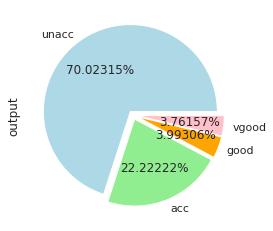

In [9]:
cars.output.value_counts().plot(kind='pie', autopct='%0.05f%%', 
                                colors=['lightblue', 'lightgreen', 'orange', 'pink'], 
                                explode=(0.05, 0.05, 0.05,0.05))

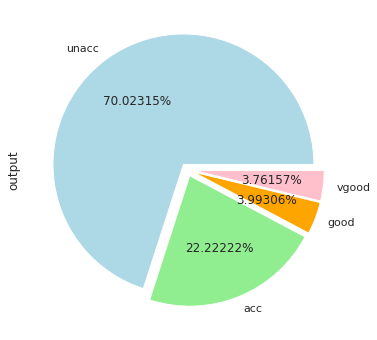

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
cars.output.value_counts().plot(kind='pie', autopct='%0.05f%%', 
                                colors=['lightblue', 'lightgreen', 'orange', 'pink'], 
                                explode=(0.05, 0.05, 0.05,0.05), ax=ax)
plt.show()

- 원핫 인코딩 적용

In [11]:
price = pd.get_dummies(cars.price, prefix='price')
maint = pd.get_dummies(cars.maint, prefix='maint')

doors = pd.get_dummies(cars.doors, prefix='doors')
persons = pd.get_dummies(cars.persons, prefix='persons')

lug_capacity = pd.get_dummies(cars.lug_capacity, prefix='lug_capacity')
safety = pd.get_dummies(cars.safety, prefix='safety')

labels = pd.get_dummies(cars.output, prefix='condition')

X = pd.concat([price, maint, doors, persons, lug_capacity, safety] , axis=1)
y = labels.values

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   price_high          1728 non-null   uint8
 1   price_low           1728 non-null   uint8
 2   price_med           1728 non-null   uint8
 3   price_vhigh         1728 non-null   uint8
 4   maint_high          1728 non-null   uint8
 5   maint_low           1728 non-null   uint8
 6   maint_med           1728 non-null   uint8
 7   maint_vhigh         1728 non-null   uint8
 8   doors_2             1728 non-null   uint8
 9   doors_3             1728 non-null   uint8
 10  doors_4             1728 non-null   uint8
 11  doors_5more         1728 non-null   uint8
 12  persons_2           1728 non-null   uint8
 13  persons_4           1728 non-null   uint8
 14  persons_more        1728 non-null   uint8
 15  lug_capacity_big    1728 non-null   uint8
 16  lug_capacity_med    1728 non-null   uint8


In [13]:
y[:5]

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]], dtype=uint8)

- 훈련과 테스트 데이터셋으로분류
- p.55 차 상태 - 4가지 값

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1382, 21), (346, 21), (1382, 4), (346, 4))

## 모델 생성 및 컴파일

In [15]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

# 입력 레이어 : 21개의 입력층 -> 21개 특성이 있으니까
input_layer = Input(shape=(X.shape[1],))

# 히든 레이어 2개 -> 첫노드 15 , 둘째노드 10 (의미 없음)
dense_layer1 = Dense(15,activation='relu')(input_layer)
dense_layer2 = Dense(10,activation='relu')(dense_layer1)

# 출력 레이어 : 4개
output = Dense(y.shape[1],activation='softmax')(dense_layer2)

# 모델 컴파일
model = Model(inputs=input_layer, outputs=output)
# 손실함수 'categorical_crossentropy', 옵티마이저 'adam', 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 15)                330       
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 534
Trainable params: 534
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련

In [16]:
history = model.fit(X_train, y_train,
                    batch_size=8, # 데이터 묶음
                    epochs=50, # 학습의 횟수
                    verbose=1, # 학습 내용 출력
                    validation_split=0.2
                    )

Epoch 1/50
139/139 [==============================] - 4s 5ms/step - loss: 1.0079 - acc: 0.6271 - val_loss: 0.8841 - val_acc: 0.6462
Epoch 2/50
139/139 [==============================] - 1s 4ms/step - loss: 0.7096 - acc: 0.7204 - val_loss: 0.7696 - val_acc: 0.6498
Epoch 3/50
139/139 [==============================] - 1s 4ms/step - loss: 0.5996 - acc: 0.7222 - val_loss: 0.6612 - val_acc: 0.6751
Epoch 4/50
139/139 [==============================] - 1s 4ms/step - loss: 0.5085 - acc: 0.7484 - val_loss: 0.5760 - val_acc: 0.7581
Epoch 5/50
139/139 [==============================] - 0s 4ms/step - loss: 0.4343 - acc: 0.8181 - val_loss: 0.5088 - val_acc: 0.8195
Epoch 6/50
139/139 [==============================] - 1s 4ms/step - loss: 0.3774 - acc: 0.8579 - val_loss: 0.4559 - val_acc: 0.8484
Epoch 7/50
139/139 [==============================] - 1s 4ms/step - loss: 0.3331 - acc: 0.8824 - val_loss: 0.4190 - val_acc: 0.8339
Epoch 8/50
139/139 [==============================] - 0s 3ms/step - loss: 0.

In [17]:
# 모델 정확도
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Scores:", score[0])
print("Test Accuracy:", score[1])

11/11 [==============================] - 0s 3ms/step - loss: 0.1043 - acc: 0.9682
Test Scores: 0.10430312901735306
Test Accuracy: 0.9682080745697021
